# 텍스트 데이터 정제 및 분할
- 리뷰에서 감성 특성을 추출할 수 있는 단어를 사용하여 분석하면 데이터의 크기를 줄이고 연산 처리 시간 및 분석 효율을 높일 수 있다.

- 온라인에서 수집한 리뷰는 HTML 태그, 특수 부호, 기호 등 특수 문자를 포함하고 있으나 실제 분석에서는 모델의 분류 성능을 저하하므로 제거
    - 정규 표현식을 정의하여 해당 특수 문자를 제거
    - 불용어는 리뷰에 포함되는 빈도수는 많지만 실제 분석에서는 큰 의미가 없으므로 제거

- 영어 리뷰에서 대문자와 소문자를 통합하거나 같은 의미를 나타내는 단어를 통일시키면 데이터의 크기를 줄일 수 있다

- 어간 추출(Stemming) 기법을 통해 리뷰에서 같은 의미를 나타내는 단어를 통일

- 등장 빈도가 2회 이상의 단어만을 선택하여 사용

- 리뷰에 포함되는 단어를 벡터값으로 변환하기 위해 인코딩 작업을 수행하여 각 단어에 대한 고유한 벡터값을 할당

In [35]:
import re
import contractions
import spacy

# spaCy 영어 모델 불러오기
nlp = spacy.load("en_core_web_sm")

# 전처리 + 표제어 추출 함수
def clean_text(text):
    # HTML 태그 제거
    text = re.sub(r'<.*?>', '', text)
    # 이모지 및 비영문 제거
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    # 축약어 확장
    text = contractions.fix(text)
    # 특수문자 제거
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 숫자 제거
    text = re.sub(r'\d+', '', text)
    # 소문자 변환
    text = text.lower()
    # 불필요한 공백 정리
    text = re.sub(r'\s+', ' ', text).strip()

    # 표제어 추출 (stopword 제외)
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

    return ' '.join(lemmas)


In [36]:
import json
import re
import contractions
import spacy
from tqdm import tqdm

# 파일 경로
input_file = 'review.json'
output_file = 'review_only.json'
chunk_size = 100000
buffer = []

# 전체 라인 수 계산
with open(input_file, 'r') as f:
    total_lines = sum(1 for _ in f)

# 전처리 + 저장 루프
with open(input_file, 'r') as fin, open(output_file, 'w') as fout:
    for line in tqdm(fin, total=total_lines, desc="Processing"):
        r = json.loads(line)
        cleaned = clean_text(r['text'])
        buffer.append({'cleaned_text': cleaned})  # 필요한 필드만 저장

        if len(buffer) >= chunk_size:
            for item in buffer:
                fout.write(json.dumps(item) + '\n')
            buffer = []

    # 남은 buffer 저장
    if buffer:
        for item in buffer:
            fout.write(json.dumps(item) + '\n')



Processing: 100%|██████████| 732435/732435 [1:52:07<00:00, 108.87it/s]  


In [37]:
import json
from tqdm import tqdm

input_file = 'review.json'
clean_file = 'review_only.json'
output_file = 'review0419_cleaned.json'

with open(input_file, 'r') as fin1, open(clean_file, 'r') as fin2, open(output_file, 'w') as fout:
    for raw_line, clean_line in tqdm(zip(fin1, fin2), desc="🔧 병합 중"):
        raw = json.loads(raw_line)
        clean = json.loads(clean_line)

        # ✅ "text" 필드 제거
        raw.pop("text", None)

        # ✅ cleaned_text 필드 그대로 추가
        raw["cleaned_text"] = clean.get("cleaned_text", "")

        # ✅ 공백 없는 JSON 저장
        fout.write(json.dumps(raw, separators=(',', ':')) + '\n')


🔧 병합 중: 732435it [00:07, 102493.99it/s]


In [39]:
import pandas as pd

df_review0419_cleaned = pd.read_json("review0419_cleaned.json", lines=True)

text = ' '.join(df_review0419_cleaned["cleaned_text"])

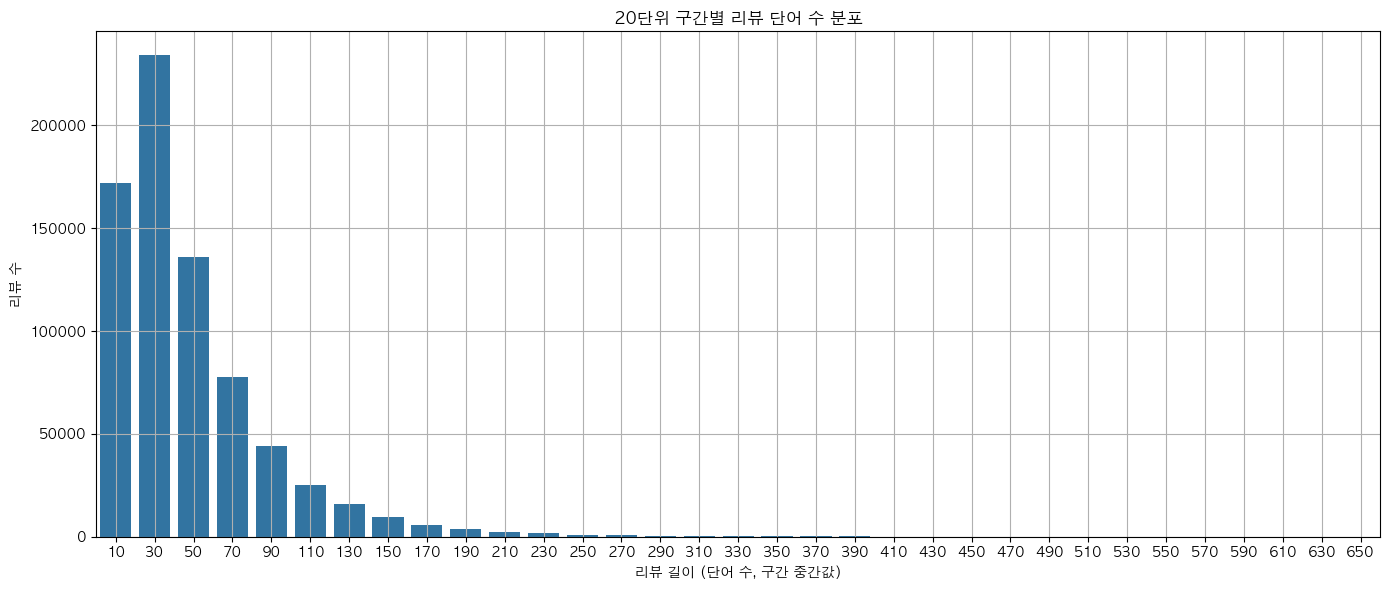

📊 리뷰 단어 수 통계
count    732435.000000
mean         47.481218
std          40.994325
min           0.000000
25%          20.000000
50%          35.000000
75%          61.000000
max         638.000000
Name: review_length, dtype: float64


In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ 단어 수 계산
df_review0419_cleaned["review_length"] = df_review0419_cleaned["cleaned_text"].apply(lambda x: len(x.split()))

# ✅ 20단위 구간 생성 (중간값: 10, 30, 50 ...)
bin_width = 20
min_bin = 0
max_bin = ((df_review0419_cleaned["review_length"].max() // bin_width) + 2) * bin_width
bins = list(range(min_bin, max_bin + 1, bin_width))
midpoints = [b + bin_width // 2 for b in bins[:-1]]  # 예: 10, 30, 50, ...

# ✅ 구간 적용
df_review0419_cleaned["length_bin"] = pd.cut(
    df_review0419_cleaned["review_length"], 
    bins=bins, 
    labels=midpoints, 
    right=False
)

# ✅ 구간별 개수 집계
group_counts = df_review0419_cleaned["length_bin"].value_counts().sort_index()

# ✅ 한글 폰트 설정 (macOS 기준)
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

# ✅ 시각화
plt.figure(figsize=(14, 6))
sns.barplot(x=group_counts.index.astype(int), y=group_counts.values)
plt.title("20단위 구간별 리뷰 단어 수 분포")
plt.xlabel("리뷰 길이 (단어 수, 구간 중간값)")
plt.ylabel("리뷰 수")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ 통계 출력
print("📊 리뷰 단어 수 통계")
print(df_review0419_cleaned["review_length"].describe())


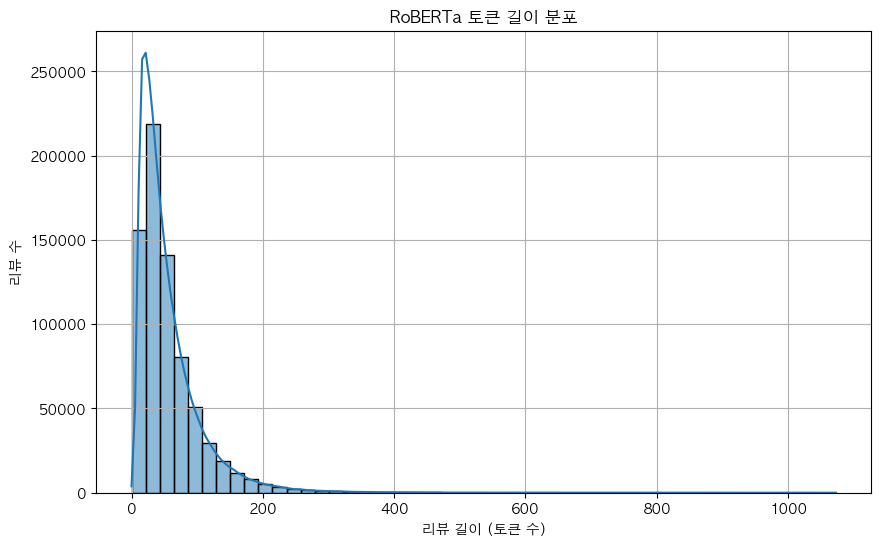

count    732435.000000
mean         56.284992
std          49.580742
min           0.000000
25%          24.000000
50%          41.000000
75%          72.000000
max        1073.000000
Name: token_length, dtype: float64


In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import RobertaTokenizer

# RoBERTa 토크나이저 로드
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# RoBERTa 토큰 길이 계산
df_review0419_cleaned["token_length"] = df_review0419_cleaned["cleaned_text"].apply(lambda x: len(tokenizer.tokenize(x)))

# 한글 깨짐 방지 (macOS 기준)
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

# 히스토그램 시각화
plt.figure(figsize=(10, 6))
sns.histplot(df_review0419_cleaned["token_length"], bins=50, kde=True)
plt.title("RoBERTa 토큰 길이 분포")
plt.xlabel("리뷰 길이 (토큰 수)")
plt.ylabel("리뷰 수")
plt.grid(True)
plt.show()

# 통계 정보 출력
print(df_review0419_cleaned["token_length"].describe())

In [72]:
# 128 토큰 초과 개수
over_128 = (df_review0419_cleaned["token_length"] > 128).sum()

# 256 토큰 초과 개수
over_256 = (df_review0419_cleaned["token_length"] > 256).sum()

# 512 토큰 초과 개수
over_512 = (df_review0419_cleaned["token_length"] > 512).sum()

print(f"128 토큰 초과 리뷰 수: {over_128}")
print(f"256 토큰 초과 리뷰 수: {over_256}")
print(f"512 토큰 초과 리뷰 수: {over_512}")

total = len(df_review0419_cleaned)
print(f"128 초과 비율: {over_128 / total:.2%}")
print(f"256 초과 비율: {over_256 / total:.2%}")
print(f"512 초과 비율: {over_512 / total:.2%}")

128 토큰 초과 리뷰 수: 55665
256 토큰 초과 리뷰 수: 6135
512 토큰 초과 리뷰 수: 180
128 초과 비율: 7.60%
256 초과 비율: 0.84%
512 초과 비율: 0.02%


In [40]:
tokens = text.split()

In [41]:
from collections import Counter

word_counts = Counter(tokens)

In [42]:
df_freq = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
df_sorted = df_freq.sort_values(by='Frequency', ascending=False)

# 상위 30개 단어 출력
print(df_sorted[:30])

           Word  Frequency
42         good     565997
52         food     497476
28        place     449799
24        order     352130
37        great     328100
337        like     292814
148        come     289221
98         time     275204
49      service     224978
15          try     217346
171         get     215982
23           go     192455
68   restaurant     172300
118        love     167956
3     delicious     165309
561         eat     158742
167        menu     147301
106     chicken     142157
316        nice     141134
166       drink     134545
109        wait     131589
273      cheese     129708
63   definitely     126980
264        want     125518
193       taste     122676
179       think     122193
679      little     122005
144       table     120705
142        look     115295
416       price     114577


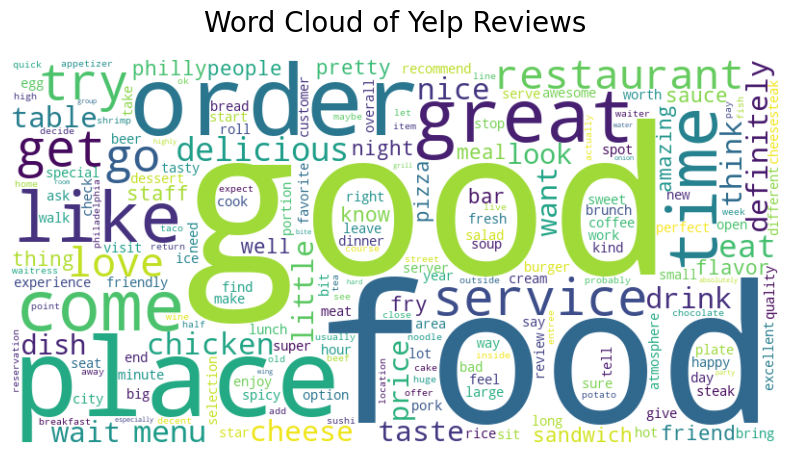

In [43]:
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 워드클라우드 생성
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# 시각화 출력
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # 축 표시 제거
plt.title("Word Cloud of Yelp Reviews", pad=20, fontsize=20)
plt.show()

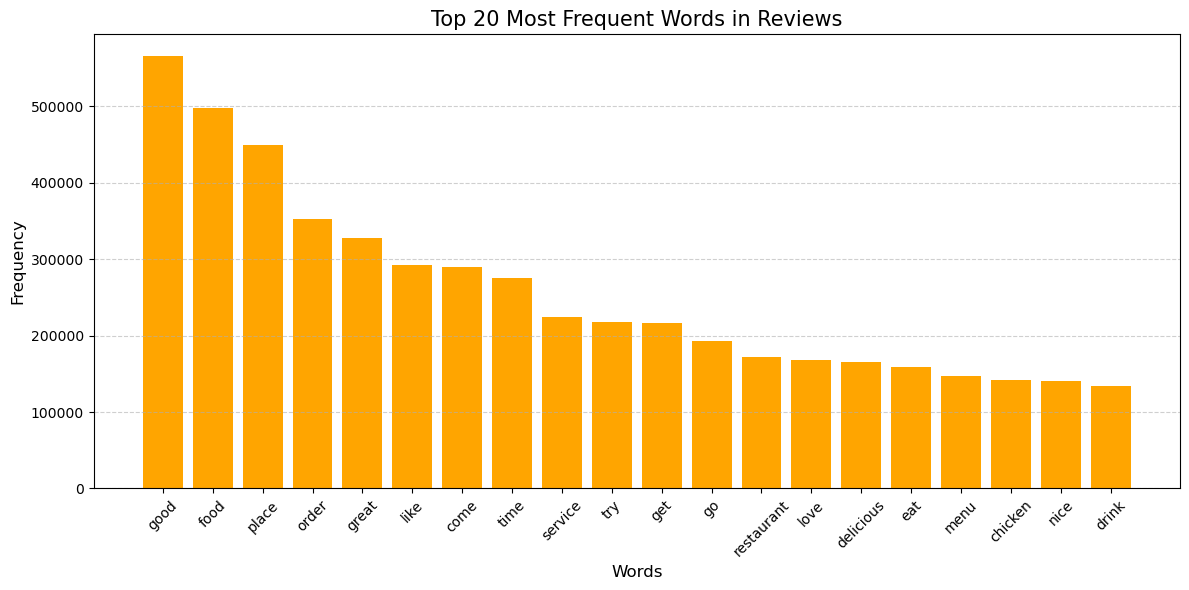

In [44]:
from collections import Counter

# 전체 단어 집합 생성
all_words = ' '.join(df_review0419_cleaned["cleaned_text"]).split()

# 단어 빈도 수 계산
word_counts = Counter(all_words)

# 데이터프레임으로 변환 및 정렬
df_freq = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])
df_sorted = df_freq.sort_values(by='Frequency', ascending=False)

# 4. 20개 단어 추출
top_20 = df_sorted.head(20)

# 5. 막대그래프 시각화
plt.figure(figsize=(12, 6))
plt.bar(top_20['Word'], top_20['Frequency'], color='orange')
plt.title('Top 20 Most Frequent Words in Reviews', fontsize=15)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# RoBERTa 임베딩 추출 코드 (문장 단위)

In [46]:
!pip install transformers torch tqdm

In [48]:
import json
import torch
from tqdm import tqdm
from transformers import RobertaTokenizer, RobertaModel

# ✅ MPS (Apple GPU) 디바이스 설정
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ MPS (Apple GPU) 사용 중")
else:
    device = torch.device("cpu")
    print("⚠️ MPS 사용 불가, CPU로 실행")

✅ MPS (Apple GPU) 사용 중


In [50]:
# ✅ 모델 로딩
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base").to(device)
model.eval()

# ✅ 배치 벡터화 함수
def get_roberta_batch_vectors(text_list):
    inputs = tokenizer(
        text_list,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        cls_vectors = outputs.last_hidden_state[:, 0, :]  # (batch_size, 768)
    
    return cls_vectors.cpu().numpy()

# ✅ 파일 경로
input_path = "review0419_cleaned.json"
output_path = "review0419_roberta_vectorized.json"

# ✅ 배치 사이즈 조정 (M1/M2는 16~64 적절)
batch_size = 32
batch_texts = []
batch_data = []

# ✅ 총 라인 수 계산
with open(input_path, 'r') as f:
    total_lines = sum(1 for _ in f)

# ✅ 배치 처리 + 저장
with open(input_path, "r") as fin, open(output_path, "w") as fout:
    for line in tqdm(fin, total=total_lines, desc="🚀 RoBERTa 벡터화 중 (batch)", unit="line"):
        data = json.loads(line)
        text = data.get("cleaned_text", "").strip()

        if text:
            batch_texts.append(text)
            batch_data.append(data)

        # 배치 처리 시점
        if len(batch_texts) >= batch_size:
            vectors = get_roberta_batch_vectors(batch_texts)
            for i, vec in enumerate(vectors):
                batch_data[i]["roberta_vector"] = vec.tolist()
                fout.write(json.dumps(batch_data[i], separators=(',', ':')) + '\n')
            batch_texts, batch_data = [], []

    # 마지막 남은 배치 처리
    if batch_texts:
        vectors = get_roberta_batch_vectors(batch_texts)
        for i, vec in enumerate(vectors):
            batch_data[i]["roberta_vector"] = vec.tolist()
            fout.write(json.dumps(batch_data[i], separators=(',', ':')) + '\n')

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
🚀 RoBERTa 벡터화 중 (batch): 100%|██████████| 732435/732435 [1:55:15<00:00, 105.91line/s] 


# 여기서부터는 다시 만들 예정입니다.

In [63]:
# ✅ 감성 분석용 CNN, LSTM, CNN+LSTM 모델 구조 (논문 기반)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
import json
from tqdm import tqdm, trange
import time
from datetime import timedelta

# ✅ GPU 디바이스 우선 설정 (CUDA → MPS → CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"✅ 사용 디바이스: {device}")

# 공통 설정
embedding_dim = 300
num_classes = 3   # 감성: Negative, Neutral, Positive

# ✅ CNN 모델
class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=300, kernel_size=3)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(300, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x).squeeze(2)
        x = self.dropout(x)
        return self.fc(x)

# ✅ LSTM 모델
class LSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size):
        super(LSTMTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 128, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        output, (hn, _) = self.lstm(x)
        x = self.dropout(hn[-1])
        return self.fc(x)

# ✅ CNN + LSTM 모델
class CNNLSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size):
        super(CNNLSTMTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=300, kernel_size=3)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.lstm = nn.LSTM(300, 128, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.pool(x).permute(0, 2, 1)
        output, (hn, _) = self.lstm(x)
        x = self.dropout(hn[-1])
        return self.fc(x)

# ✅ 학습 루프 샘플 함수

def train_model(model, dataset, num_epochs=30, batch_size=64):
    train_len = int(len(dataset) * 0.8)
    val_len = len(dataset) - train_len
    train_set, val_set = random_split(dataset, [train_len, val_len])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=torch.cuda.is_available())
    val_loader = DataLoader(val_set, batch_size=batch_size, pin_memory=torch.cuda.is_available())

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    epoch_times = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        start_time = time.time()

        for x_batch, y_batch in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}]", leave=False):
            x_batch, y_batch = x_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        elapsed = time.time() - start_time
        epoch_times.append(elapsed)

        avg_epoch_time = np.mean(epoch_times)
        remaining_time = avg_epoch_time * (num_epochs - epoch - 1)
        eta_str = str(timedelta(seconds=int(remaining_time)))

        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Time: {elapsed:.1f}s | ETA: {eta_str}")

    # 검증 성능 출력
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device, non_blocking=True)
            output = model(x_batch)
            preds = torch.argmax(output, dim=1).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)

    print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


✅ 사용 디바이스: mps


In [64]:
run_with_real_data("review0419_cleaned.json")

📄 데이터 로딩 중: 732435it [00:31, 22905.44it/s] 


[Epoch 1] Loss: 4508.7372 | Time: 417.2s | ETA: 3:21:38


[Epoch 2] Loss: 3972.7735 | Time: 431.0s | ETA: 3:17:55


[Epoch 3] Loss: 3776.0185 | Time: 436.0s | ETA: 3:12:37


[Epoch 4] Loss: 3640.6123 | Time: 440.8s | ETA: 3:06:52


[Epoch 5] Loss: 3512.2216 | Time: 442.1s | ETA: 3:00:35


[Epoch 6] Loss: 3389.8433 | Time: 440.8s | ETA: 2:53:51


[Epoch 7] Loss: 3273.5201 | Time: 441.7s | ETA: 2:46:59


[Epoch 8] Loss: 3153.3644 | Time: 440.9s | ETA: 2:39:58


[Epoch 9] Loss: 3028.9577 | Time: 440.9s | ETA: 2:32:53


[Epoch 10] Loss: 2925.3933 | Time: 440.3s | ETA: 2:25:43


[Epoch 11] Loss: 2808.2107 | Time: 440.2s | ETA: 2:18:31


[Epoch 12] Loss: 2701.0881 | Time: 439.7s | ETA: 2:11:17


[Epoch 13] Loss: 2592.9823 | Time: 439.8s | ETA: 2:04:02


[Epoch 14] Loss: 2497.9682 | Time: 439.9s | ETA: 1:56:47


[Epoch 15] Loss: 2411.8966 | Time: 440.3s | ETA: 1:49:31


[Epoch 16] Loss: 2320.6953 | Time: 437.8s | ETA: 1:42:13


[Epoch 17] Loss: 2254.9884 | Time: 428.1s | ETA: 1:34:47


[Epoch 18] Loss: 2179.5149 | Time: 416.8s | ETA: 1:27:16


[Epoch 19] Loss: 2108.5674 | Time: 416.3s | ETA: 1:19:48


[Epoch 20] Loss: 2061.2521 | Time: 418.0s | ETA: 1:12:24


[Epoch 21] Loss: 2005.9624 | Time: 415.3s | ETA: 1:05:01


[Epoch 22] Loss: 1945.6756 | Time: 414.9s | ETA: 0:57:41


[Epoch 23] Loss: 1899.7590 | Time: 417.2s | ETA: 0:50:23


[Epoch 24] Loss: 1857.3818 | Time: 415.8s | ETA: 0:43:07


[Epoch 25] Loss: 1810.5551 | Time: 414.3s | ETA: 0:35:53


[Epoch 26] Loss: 1781.0198 | Time: 422.0s | ETA: 0:28:41


[Epoch 27] Loss: 1739.5421 | Time: 426.5s | ETA: 0:21:30


[Epoch 28] Loss: 1707.0902 | Time: 429.9s | ETA: 0:14:20


[Epoch 29] Loss: 1675.6850 | Time: 426.7s | ETA: 0:07:10


[Epoch 30] Loss: 1647.9708 | Time: 418.8s | ETA: 0:00:00
              precision    recall  f1-score   support

    Negative       0.77      0.74      0.76     26360
     Neutral       0.42      0.39      0.40     19181
    Positive       0.90      0.92      0.91    100933

    accuracy                           0.82    146474
   macro avg       0.69      0.68      0.69    146474
weighted avg       0.81      0.82      0.81    146474



In [6]:
run_with_real_data("review0419_roberta_vectorized.json")

NameError: name 'run_with_real_data' is not defined